### 1. Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [2]:
import pickle
import geopandas
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import arcgis
from arcgis.gis import GIS

/home/zmey56/anaconda3/lib/python3.7/site-packages/arcgis/features/_data/geodataset/utils.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime,


In [3]:
# прочесть данные
with open('/home/zmey56/Yandex.Disk/Stepik/Final_3/Data/agg_statistic2016.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
region = pd.read_csv('/home/zmey56/Yandex.Disk/Stepik/Final_3/Data/regions.csv', sep=";")

In [5]:
# границы нью-йорка
nyc_longitude_west = -74.25559
nyc_longitude_east = -73.70001
nyc_latitude_north = 40.91553
nyc_latitude_south = 40.49612

# Координаты Empire State Building
empire_location = (40.748306, -73.985756)
empire_long = -73.985756
empire_lat = 40.748306

In [6]:
# посчитаем количество ячеек из которых в мае не было поездок и общее количество поездок такси
reg_count = np.array(data.sum(axis=1))
print("Не было поездок: ", np.count_nonzero(reg_count==0))

Не было поездок:  1283


### 2. Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

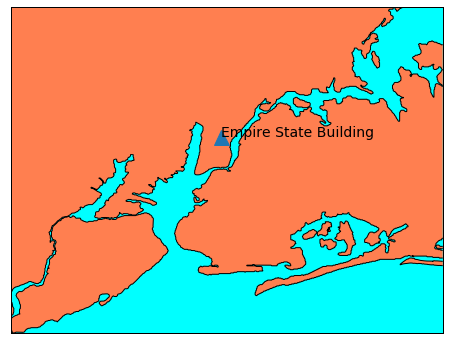

In [7]:
plt.figure(figsize=(12,6))

map = Basemap(llcrnrlon=nyc_longitude_west,llcrnrlat=nyc_latitude_south,urcrnrlon=nyc_longitude_east,
              urcrnrlat=nyc_latitude_north, resolution = 'f')

map.plot(empire_long, empire_lat, '^', markersize = 15)
plt.text(empire_long, empire_lat, 'Empire State Building', fontsize = 14)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

plt.show()

### 3. Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [11]:
longs = np.unique(region[['west', 'east']].values)
lats = np.unique(region[['north', 'south']].values)

lon, lat = np.meshgrid(longs, lats)

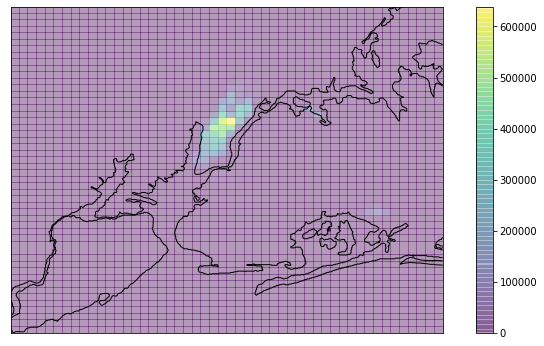

In [12]:
plt.figure(figsize=(12,6))

map = Basemap(llcrnrlon=nyc_longitude_west,llcrnrlat=nyc_latitude_south,urcrnrlon=nyc_longitude_east,
              urcrnrlat=nyc_latitude_north, resolution = 'f')

#Тепловая карта
map.pcolormesh(lon, lat, reg_count.reshape(50, 50).transpose(), latlon = True, alpha = 0.4)
plt.colorbar()

map.drawcoastlines()

plt.show()

**карта окрасилась в фиолетовый, так как отоброзились видимо нулевые точки, дальше проверю это более простым методом**

In [13]:
# убираю нули

dataset = pd.DataFrame({'west': region.west, 'south': region.south, 'count': reg_count}, columns=['west', 'south', 'count'])
df = dataset[dataset["count"]>0]
west_1 = np.array(df.west)
south_1 = np.array(df.south)
count_1 = np.array(df['count'])

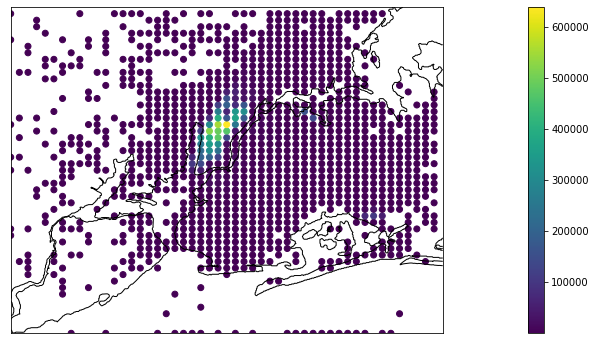

In [14]:
plt.figure(figsize=(12,6))

map = Basemap(llcrnrlon=nyc_longitude_west,llcrnrlat=nyc_latitude_south,urcrnrlon=nyc_longitude_east,
              urcrnrlat=nyc_latitude_north, resolution = 'f')

plt.scatter(west_1, south_1, c=count_1)
plt.colorbar()

map.drawcoastlines()

plt.show()

### 4. Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [15]:
import folium

In [16]:
# нахожу центр карты
nyc_longitude = nyc_longitude_east-((nyc_longitude_east-nyc_longitude_west)/2)
nyc_latitude = nyc_latitude_north - ((nyc_latitude_north-nyc_latitude_south)/2)

In [17]:
nyc_longitude

-73.9778

In [18]:
# координыты статуи свободы
sl_longitude = -74.044569
sl_latitude = 40.689047

In [19]:
map_ny = folium.Map(location=[nyc_latitude, nyc_longitude],
               tiles='Stamen Toner',
               zoom_start=13)

folium.Marker(
    location=[sl_latitude, sl_longitude],
    popup='Statue of Liberty',
    icon=folium.Icon(color='green')
).add_to(map_ny)

In [20]:
map_ny

### 5. Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [21]:
import json
import requests
import geojson
import branca.colormap as cm

In [22]:
reg_mean = np.array(data.mean(axis=1))

In [23]:
list_of_features = []
for ind in region.index:
    poly = geojson.Polygon([[[region.iloc[ind].west, region.iloc[ind].south], 
                             [region.iloc[ind].west, region.iloc[ind].north],
                             [region.iloc[ind].east, region.iloc[ind].north], 
                             [region.iloc[ind].east, region.iloc[ind].south],
                             [region.iloc[ind].west, region.iloc[ind].south]]])
    feature = geojson.Feature(geometry=poly, id=str(ind), properties={"name": "reg. {}".format(int(region.iloc[ind].region))})
    list_of_features.append(feature)
features = geojson.FeatureCollection(list_of_features)

In [24]:
vmin = reg_mean.min()
vmax = reg_mean.max()
width = vmax - vmin
color_func = cm.LinearColormap(['white', 'green', 'cyan', 'blue', 'magenta', 'red'],
                               vmax = vmax, vmin = vmin,
                               index=[vmin, 20, 0.3*width, 0.6*width, 0.9*width, 1.0*vmax])
color_func

In [25]:
map_nyc = folium.Map(location=[(nyc_latitude_south+nyc_latitude_north)/2, (nyc_longitude_east+nyc_longitude_west)/2],
                     zoom_start = 11, tiles= 'cartodbpositron')

folium.Marker([40.748817, -73.985428], popup='Empire State Building').add_to(map_nyc)
folium.Marker([sl_latitude, sl_longitude], popup='Statue of Liberty').add_to(map_nyc)
folium.Marker([40.6435529, -73.78211390000001], popup= 'New York John F. Kennedy International Airport').add_to(map_nyc)
folium.Marker([40.7769271, -73.87396590000003], popup= 'LaGuardia Airport').add_to(map_nyc)

folium.Marker([region.iloc[1177].south+0.005, region.iloc[1177].west+0.005], popup= '1178').add_to(map_nyc)

folium.GeoJson(
    features,
    style_function=lambda feature: {
        'fillColor': color_func(reg_mean[int(feature['id'])]),
        'color': 'black',
        'weight': 0.2,
        'dashArray': '5, 5'
    }
).add_to(map_nyc)

color_func.caption = "Mean value of trips"
map_nyc.add_child(color_func)

map_nyc

### 6. Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [26]:
regions_left = []
for ind, val in enumerate(reg_mean):
    if val >= 5:
        regions_left.append(int(ind))
print ("Число оставшихся регионов: %d" % len(regions_left))

Число оставшихся регионов: 102


In [27]:
def custom_color_map(value):
    global regions_left
    if value in regions_left:
        return '#008000'
    else:
        return '#ff0000'

In [28]:
map_nyc_2 = folium.Map(location=[(nyc_latitude_south+nyc_latitude_north)/2, (nyc_longitude_east+nyc_longitude_west)/2],
                     zoom_start = 12, tiles= "Stamen Terrain")

folium.Marker([40.748817, -73.985428], popup='Empire State Building''Statue of Liberty').add_to(map_nyc_2)
folium.Marker([sl_latitude, sl_longitude], popup= 'Statue of Liberty').add_to(map_nyc_2)

folium.GeoJson(
    features,
    style_function=lambda feature: {
        'fillColor': custom_color_map(int(feature['id'])),
        'color': 'black',
        'weight': 0.2,
        'dashArray': '5, 5',
    }
).add_to(map_nyc_2)

map_nyc_2